In [5]:
import torch
import torch.nn.functional as F

import sys
sys.path.append('../src/')

from mscgpt.data_handler import DataHandler
from mscgpt.tokenizer import Tokenizer
from mscgpt.gpt import MicroSCGPT, GeneExpressionRegressor


In [17]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{DEVICE=}')
BATCH_SIZE = 32
CONTEXT_SIZE = 128
LEARNING_RATE = 1e-4
N_HEADS = 4
N_LAYERS = 4
N_EMBED = 32
N_EPOCHS = 30
INTERVAL_EVAL = 100
N_EVAL = 200
DROPOUT = .1
MASK_P = .2

DEVICE='cpu'


In [18]:
import os

tk = Tokenizer()
dh = DataHandler(BATCH_SIZE, CONTEXT_SIZE, tk.pad_token, device=DEVICE)

for fname in os.listdir('../data/pretrain/'):
    print(f"Loading {fname}...")
    tokenized_data = tk.load_pretraining_dataset(fname.split('.')[0])
    dh.load_dataset(tokenized_data)

print(f"Pretraining dataset size: {dh.training_set_size} cells.")

> Tokenizer: 2000 genes successfully loaded.
Loading depmap2000mv.tk...
> Data Handler: Dataset successfully loaded.
Pretraining dataset size: 967 cells.


In [19]:
@torch.no_grad()
def estimate_loss(model_gpt, model_gexpr, eval_iters):
  out = {}
  model_gpt.eval()
  model_gexpr.eval()
  for split in ('train', 'val'):
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      x_gid, x_bin = dh.get_batch(split)
      masked_gid, masked_bin, mask = dh.generate_mask(x_gid, x_bin, tk.pad_token, MASK_P)
      x_emb = model_gpt(masked_gid, masked_bin)
      estimate = model_gexpr(x_emb)
      losses[k] = dh.gene_expression_loss(x_gid, x_bin, estimate, mask).item()
    out[split] = losses.mean()
  model_gpt.train()
  model_gexpr.train()
  return out

In [21]:
gpt = MicroSCGPT(CONTEXT_SIZE, tk.bins_size, tk.vocab_size, N_HEADS, N_LAYERS, N_EMBED, N_EMBED, DROPOUT)
gexpr = GeneExpressionRegressor(CONTEXT_SIZE, N_EMBED, tk.n_genes)
gpt = gpt.to(DEVICE)
gexpr = gexpr.to(DEVICE)
optimizer = torch.optim.AdamW(
  list(gpt.parameters()) + list(gexpr.parameters()), 
  lr=LEARNING_RATE
)

> MicroSCGPT: Model initialized with 96640 parameters.


In [22]:
#print(f'> Starting training on {DEVICE}: {torch.cuda.get_device_name(0)}.')
print(f'> Starting training on {DEVICE}')

STEPS_PER_EPOCH = dh.training_set_size // BATCH_SIZE # Every cell seen on average once
N_TRAIN_STEPS = N_EPOCHS * STEPS_PER_EPOCH

print(f"> #epochs: {N_EPOCHS}, #steps per epoch: {STEPS_PER_EPOCH}, #total steps: {N_TRAIN_STEPS}")

rec_loss = []
for step in range(N_TRAIN_STEPS):
  if step > 0 and not step % (STEPS_PER_EPOCH): # LR decay every epoch
    optimizer.param_groups[0]["lr"] *= 0.9
  if not (step % INTERVAL_EVAL) or step == N_TRAIN_STEPS - 1:
    loss = estimate_loss(gpt, gexpr, N_EVAL)
    print(f'Step {step}, loss={(1000*loss["train"]):.3f}e-3 (train), {(1000*loss["val"]):.3f}e-3 (val)')
  x_gid, x_bin = dh.get_batch("train")
  masked_gid, masked_bin, mask = dh.generate_mask(x_gid, x_bin, tk.pad_token, MASK_P)
  x_emb = gpt(masked_gid, masked_bin)
  estimate = gexpr(x_emb)
  loss = dh.gene_expression_loss(x_gid, x_bin, estimate, mask)
  rec_loss.append(float(loss.detach()))
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

> Starting training on cpu
> #epochs: 5, #steps per epoch: 30, #total steps: 150
Step 0, loss=126.228e-3 (train), 124.806e-3 (val)
Step 100, loss=118.859e-3 (train), 118.760e-3 (val)
Step 149, loss=118.074e-3 (train), 117.676e-3 (val)


Text(0, 0.5, 'log(loss)')

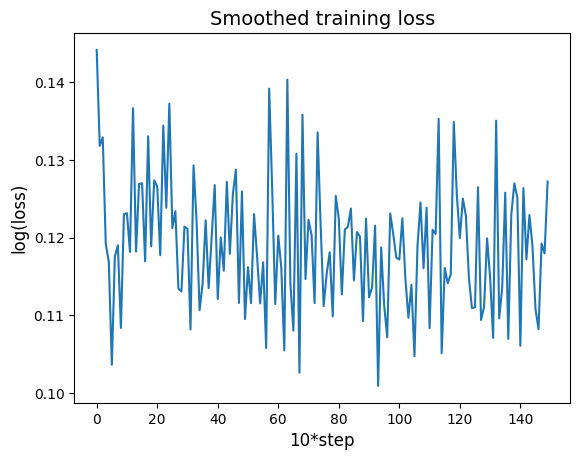

In [28]:
import matplotlib.pyplot as plt

#plt.plot(torch.tensor(rec_loss[:-15]).view(-1, 100).log().mean(axis=-1))
plt.plot(torch.tensor(rec_loss))
plt.title("Smoothed training loss", fontsize=14)
plt.xlabel("10*step", fontsize=12)
plt.ylabel("log(loss)", fontsize=12)

In [10]:
# The training loss seems to have settled :)
# Total running time: 49min41 (we approach the limits of my single GPU)
# Average speed: 21 it/s

In [29]:
# Saving pretraining parameters
torch.save(gpt.state_dict(), '../data/assets/gpt.params')
torch.save(gexpr.state_dict(), '../data/assets/gexpr.params')